# 2D Bicopter (Quadcopter)

We consider the 2D (vertical $z$ and horizontal axis $y$) quadcopter problem, and consider the following dynamics


State: $$[y, z, v_y, v_z]$$

Near hover Dynamics:
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y\\ \dot v_z\end{bmatrix} = \begin{bmatrix}v_x \\ v_y \\ -T \sin(\phi) \\ T \cos(\phi) - g\end{bmatrix}, \text{with } u=[\phi, T]$$


Approximation of near hover Dynamics: 
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y \\ \dot v_z\end{bmatrix}=\dot{X}=\begin{bmatrix}v_y \\ v_z \\-g\tan(\phi) \\ T-g\end{bmatrix}=\begin{bmatrix}v_y \\ v_z \\ -gu_1 \\ u_2 - g\end{bmatrix}, \text{with } u=[\tan(\phi), T]$$

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys; sys.version

'3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) \n[GCC 12.3.0]'

In [30]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np
import seaborn as sns

import matplotlib
import pickle as pkl
import pandas as pd

import warnings

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
import hj_reachability as hj
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF, utils
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment

from refine_cbfs import HJControlAffineDynamics, TabularControlAffineCBF

## Setup Problem (dynamics, environment and CBF)

### Dynamics

In [6]:
class CrazyflieDynamics(ControlAffineDynamics):
    """
    Simplified dynamics, and we need to convert controls from phi to tan(phi)"""
    STATES = ["y", "z", "v_y", "v_z"]
    CONTROLS = ["tan(phi)", "T"]
    def __init__(self, params, test=True, **kwargs):
        self.g = params.get("g", 9.81)
        # self._A = jax.vmap(jax.grad(self.f, argnums=0), in_axes=(0, 0, None))
        # self._A = jax.vmap(jax.jacfwd(self.f, argnums=0), in_axes=(0, 0, None))
        _A_single = lambda x, u, t: jax.jacfwd(lambda x: self.__call__(x,u,t))(x)
        self._A = jax.vmap(_A_single, in_axes=(0, 0, 0), out_axes=0)
        super().__init__(params, test, **kwargs)
    
    def open_loop_dynamics(self, state, time: float = 0.0):
        return jnp.array([state[2], state[3], 0.0, -self.g])
    
    def f(self, state, control, time=0.0):
        return self.open_loop_dynamics(state, time) + self.control_matrix(state, time) @ control

    def control_matrix(self, state, time: float = 0.0):
        return jnp.array([[0.0, 0.0], [0.0, 0.0], [self.g, 0.0], [0.0, 1.0]])
    
    def disturbance_jacobian(self, state, time: float = 0.0):
        return jnp.expand_dims(jnp.zeros(4), axis=-1)
    
    def state_jacobian(self, state, control, time: float = 0.0):
        if state.ndim == 1:
            state = jnp.expand_dims(state, axis=0)
            control = jnp.expand_dims(control, axis=0)
        if isinstance(time, float):
            # repeat based on batch size
            time = jnp.repeat(jnp.expand_dims(time, axis=0), state.shape[0], axis=0)
        return self._A(state, control, time).squeeze(axis=0)
    

In [7]:
dyn = CrazyflieDynamics({'dt': 0.05}, test=True)

umax = jnp.array([jnp.tan(np.pi / 6), 1.5 * 9.81])
umin = jnp.array([-jnp.tan(np.pi / 6), 0.0])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Environment:
### Boundary of grid
Boundary of grid is defined below by the state domain
### Environment / obstacles
Safe set is delimited by the state space boundary and by obstacles

In [8]:
state_domain = hj.sets.Box(lo=jnp.array([-6., -0.1, -5., -5.]), 
                           hi=jnp.array([6., 4.1, 5., 5.]))
grid_resolution = (31, 31, 25, 25)  
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution)

In [9]:
boundary = np.array([[-5., 5.], [0., 4.], [-10., 10.], [-10., 10.]])
obstacle1 = np.array([[-2., 0.], [1., 3.], [-100., 100.], [-100., 100.]])
obstacle2 = np.array([[1., 3.], [2., 4.], [-100., 100.], [-100., 100.]])
obstacles = [obstacle1, obstacle2]

In [10]:
def build_sdf(boundary, obstacles):
    """
    Args:
        boundary: [n x 2] matrix indicating upper and lower boundaries of safe space
        obstacles: list of [n x 2] matrices indicating obstacles in the state space
    Returns:
        Function that can be queried for unbatched state vector
    """
    def sdf(x):
        sdf = jnp.min(jnp.array([x - boundary[:,0], boundary[:,1] - x]))
        for obstacle in obstacles:
            obstacle_sdf = jnp.max(jnp.array([obstacle[:,0] - x, x - obstacle[:,1]]))
            sdf = jnp.min(jnp.array([sdf, obstacle_sdf]))
        return sdf
    return sdf

In [11]:
sdf = build_sdf(boundary, obstacles)

In [12]:
sdf_values = hj.utils.multivmap(sdf, jnp.arange(grid.ndim))(grid.states)

Text(0.5, 1.0, 'Obstacle and safe set')

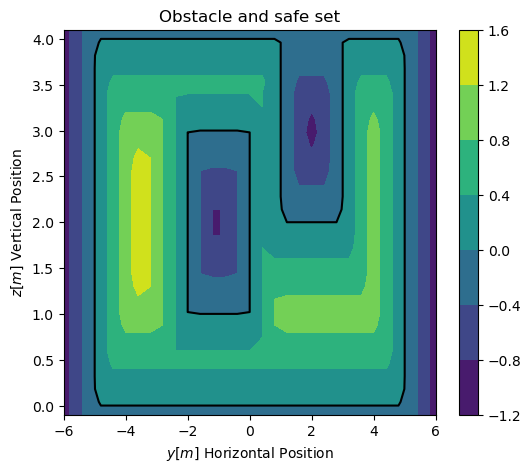

In [20]:
fig = plt.figure(figsize=(6, 5))
f = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], 
                 sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k')
plt.colorbar(f)
plt.xlabel("$y [m]$ Horizontal Position")
plt.ylabel("$z [m]$ Vertical Position")
plt.title("Obstacle and safe set")

### Initial Control Barrier Function

In [21]:
class CrazyflieCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, test=False, **kwargs):
        self.scaling = params["scaling"]
        self.center = params["center"]
        self.offset = params["offset"]
        self._vf_grad = jax.vmap(jax.grad(self.vf, argnums=0), in_axes=(0, None))
        super().__init__(dynamics, params, test=False, **kwargs)
    
    def vf(self, state, time=0.0):
        val = (self.offset - jnp.sum(self.scaling * (state - self.center) ** 2, axis=-1))
        return val
        # return jnp.where(val > 0, val, 0.1 * val)
    
    def _grad_vf(self, state, time=0.0):
        return self._vf_grad(state, time)


In [22]:
cbf_cf_params = {"scaling": jnp.array([2.0, 2.0, 1.0, 1.0]), "offset": 2.0, "center": jnp.array([-3.5, 2., 0.0, 0.])}
cbf_cf = CrazyflieCBF(dyn, cbf_cf_params, test=False)

In [23]:
tabular_cbf = TabularControlAffineCBF(dyn, cbf_cf_params, test=False, grid=grid)
tabular_cbf.tabularize_cbf(cbf_cf)

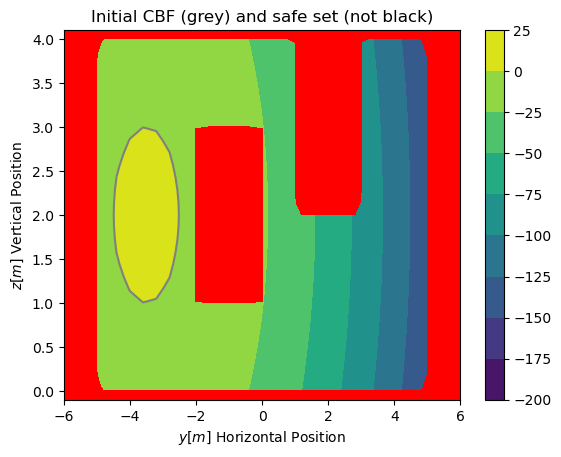

In [38]:
f = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], 
                 tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey')
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            init_safe_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[-10, 0], colors='red')
plt.colorbar(f)
plt.xlabel("$y [m]$ Horizontal Position")
plt.ylabel("$z [m]$ Vertical Position")
plt.title("Initial CBF (grey) and safe set (not black)");

# refineCBF: Refining a CBF with DP-based reachability

In [28]:
dyn_hjr = HJControlAffineDynamics(dyn, control_space=hj.sets.Box(umin, umax))

backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(init_safe_values))


In [29]:
init_values = tabular_cbf.vf_table
initial_time = 0.
final_time = -5.
times = jnp.linspace(initial_time, final_time, 51)
target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

100%|##########|  5.0000/5.0 [01:10<00:00, 14.03s/sim_s]


In [33]:
from scipy.interpolate import interp1d

In [34]:
times_sim = jnp.linspace(0., 10., len(times))
target_values_f = interp1d(times_sim, target_values, axis=0)

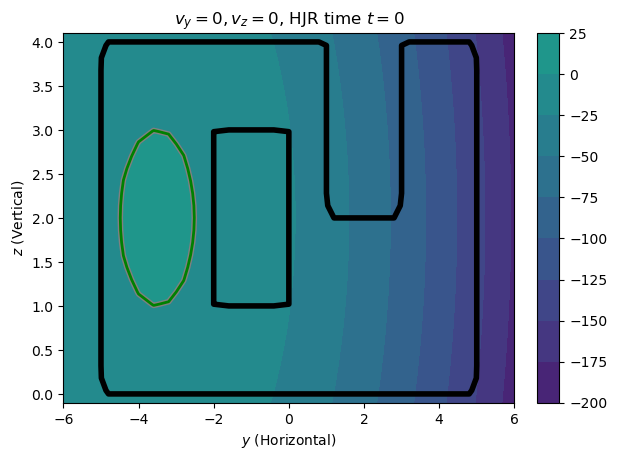

In [133]:
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

frames = []
for i in range(len(target_values)):
    curvals = target_values[i]
    frames.append(curvals)

cv0 = frames[0]
vmax = np.abs(cv0).max()
cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                 cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, vmax=vmax, vmin=-vmax)
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey', linewidths=4)  
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           init_safe_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k', linewidths=4)
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='green', linewidths=2)
cb = fig.colorbar(cf, cax=cax)
tx = ax.set_title(f'HJR time $t=0$')
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont
    arr = frames[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], arr, vmax=vmax, vmin=-vmax)
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cax.cla()
    fig.colorbar(cf, cax=cax)
    tx.set_text('HJR time t={:.2f}'.format(np.abs(times[idi].item())))


# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)))

plt.show()

In [129]:
from IPython.display import HTML

# Display the animation directly in the notebook
HTML(ani.to_jshtml())

/tmp/ipykernel_719812/747130869.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cont.collections[0].remove()
/opt/anaconda3/envs/ros_noetic/lib/python3.9/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


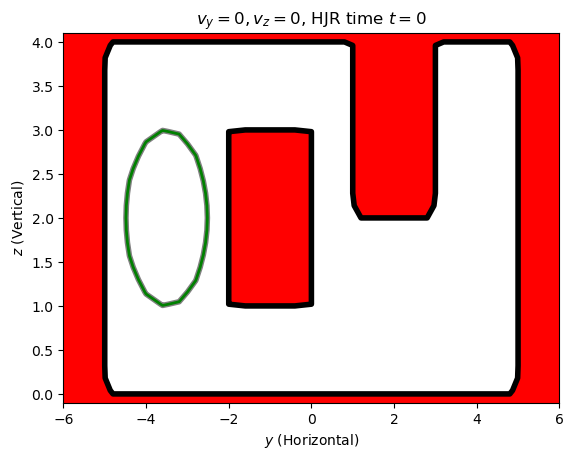

In [131]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)

frames = []
for i in range(len(target_values)):
    curvals = target_values[i]
    frames.append(curvals)

ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey', linewidths=4)  
ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           init_safe_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[-10, 0], colors='red')
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           init_safe_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k', linewidths=4)
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='green', linewidths=2)
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont
    arr = frames[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    tx.set_text('$v_y=0, v_z=0$, HJR time t={:.2f}'.format(np.abs(times[idi].item())))


# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)))

plt.show()

## Online implementation

AA203 text: Consider the goal of developing a self-righting quadrotor, i.e., a flying drone that you can chuck into the air at a range of poses/velocities which will autonomously regulate to level flight while obeying dynamics/controls/operational-envelope constraints.

### First, we extend the CBF to 6 dimensions by repeating it along X, XDOT axis

In [ ]:
x_nom = jnp.array([0.0, 3.0, 0.0, 0.0])
u_nom = jnp.array([0.0, 9.81])
A, B = dyn.linearized_dt_dynamics(x_nom, u_nom)

Q = jnp.diag(jnp.array([1.0, 1.0, 0.1, 0.1]))
R = jnp.diag(jnp.array([1.0, 1.0]))

K = utils.lqr(A, B, Q, R)

A_cl = A - B @ K
# assert np.all(np.linalg.eigvals(A_cl) < 0).all() 

In [ ]:
nominal_control = lambda u_ref, x_ref, F: lambda x, t: np.atleast_2d(np.clip(u_ref - 
                                (F @ (x - x_ref).T).T, umin, umax))

In [ ]:
x_goal = jnp.array([4.0, 3.0, 0.0, 0.0])
u_goal = jnp.array([0.0, 9.81])
nom_control = nominal_control(u_goal, x_goal, K)
alpha = lambda x: x
cbf_asif = ControlAffineASIF(dyn, cbf_cf, alpha=alpha, nominal_policy=nom_control,
                             umin=umin, umax=umax)

In [ ]:
x0 = jnp.array([-3.0, 2.0, 0.0, 0.0])
experiment = RolloutTrajectory('quad', start_x=x0, n_sims_per_start=1, t_sim=8)

In [ ]:
experiment.run(dyn, {"Nominal": nom_control, "CBF": cbf_asif})

In [ ]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)
results_df = experiment.run(extended_dyn, {'Nominal': nom_control, 
                                           'Analytical': cbf_asif,
                                           'CBVF': cbvf_asif})

In [ ]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 2], start_x=x0, n_sims_per_start=1, t_sim=8)
ss_exp.plot(extended_dyn, results_df)

# Plot of safe sets 

Note: you can either generate your own value functions using the code above or download the `.npy` files used for generating the conceptual images in the paper by downloading the two files from this [link](https://drive.google.com/drive/folders/1196k2vBY-57w85-30rhfdUeO3w160ML6?usp=sharing)



In [ ]:
conservative_case_sets_plot = False  #True
case_number = 1  # 2, 3

In [ ]:
if conservative_case_sets_plot:
    offset_y = 12
    offset_phi = 12
    value_function = np.load("quad_2d/target_values_conservative.npy")
else:
    offset_y = 5
    offset_phi = 9
    value_function = np.load("quad_2d/target_values_invalid.npy")

In [ ]:
fig_sets = plt.figure(figsize=(10, 10))
plt.axis('off')

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
colors = np.array(colors)

plt.contourf(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
             safe_values[:, offset_y, :, offset_phi], levels=[-10, 0], 
             colors=np.array([colors[0]]), alpha=0.6)

if case_number == 1:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                    value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                    colors=[colors[3]], linewidths=10)
elif case_number == 2:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.2)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[3][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[2]], linewidths=10)
elif case_number == 3:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.6)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[3][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.4)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[10][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.2)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[-1][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[-1]], linewidths=10)    
plt.tight_layout()

# Visualizations for the paper

In [ ]:
exp = StateSpaceExperiment('quad', start_x=np.random.rand(6), x_indices=[0, 2], n_sims_per_start=1, 
                           t_sim=8)

In [ ]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

In [ ]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 'xtick.labelsize': 28, 'ytick.labelsize': 28,
'lines.linewidth': 5}
matplotlib.rcParams.update(params)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
ax = axs[0]

lim = -1
exp.plot(extended_dyn, pd.read_csv('quad_2d/invalid_results.csv'), ax=ax, color=chosen_colors)
x0 = np.array([15., -3., 2.5, -2., np.pi / 4, 1])
x_goal = np.array([0., 0., 1.5, 0., 0., 0.])

ax.lines[3].set_linestyle((0, (5, 5, 2, 5)))
ax.lines[6].set_dashes([4, 4, 2, 4, 2, 4])
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')

l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], 
                 colors='grey', alpha=.3)
cs = ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[0], 
                colors='grey', alpha=.6, linewidths=2)

ax.set_ylim([0, 5])
ax.set_xlim([-9,16])
ax.set_xlabel('$x$ (Horizontal position) [m]')
ax.set_ylabel('$y$ (Height) [m]')


ax = axs[1]
lim = -1
exp.plot(extended_dyn, pd.read_csv("quad_2d/conservative_results.csv"), ax=ax,
                 color=chosen_colors)
ax.lines[3].set_linestyle((0, (5, 5, 2, 5)))
ax.lines[6].set_dashes([4, 4, 2, 4, 2, 4])


x0 = np.array([0., 4., 7., -2., -np.pi/4, 0.])
x_goal = np.array([6., 0., 9., 0., 0., 0.])
ax.plot()
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], 
                 colors='grey', alpha=.3)
ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
           new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[0], 
           colors='grey', alpha=.6, linewidths=2)

ax.set_xlim([-2, 10])
ax.set_ylim([5,10])
ax.set_xlabel('$x$ (Horizontal position) [m]')

fig.tight_layout()
axs[0].set_title('Invalid (unsafe) candidate CBF')
axs[1].set_title('Conservative candidate CBF')
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], 
                    ncol=2, bbox_to_anchor=[.5, 0.1], loc='center', frameon=True, handletextpad=0.6)

axs[0].legend(axs[0].lines[::3], ["Nominal $\hat \pi$", "Candidate CBF", "Converged CBVF"], 
              bbox_to_anchor=[.5, .8], ncol=1, columnspacing=1.5, 
              handletextpad=0.8, loc='center', frameon=True)
axs[1].add_artist(leg)

# plt.savefig("quad_trajectories.png", dpi=400, bbox_inches='tight')

# Animations

In [ ]:
from quad_2d.animate_quad import animate_multi_planar_quad

In [ ]:
produce_videos = True
conversative_case = True

In [ ]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)

if conversative_case:
    x0 = np.array([0, 4., 7., -2., - np.pi/4, 0.])
    x_goal = np.array([6., 0., 9., 0., 0., 0.])
    xlims = [-2, 10]
    bbox1 = [.5, .35]
    bbox2 = [.5, .2]
    traj_data = pd.read_csv('quad_2d/conservative_results.csv')

else: 
    x0 = np.array([15., -3., 2.5, -2., np.pi/4, 1.])
    x_goal = np.array([0., 0., 1.5, 0., 0., 0.])
    xlims = [-5, 18]
    bbox1 = [.5, .8]
    bbox2 = [.5, .65]
    traj_data = pd.read_csv('quad_2d/invalid_results.csv')

times = traj_data.t.unique()
cbf_data = traj_data[traj_data.controller == "Analytical"]
cbvf_data = traj_data[traj_data.controller == "CBVF"]
x_vals = np.array([cbf_data.loc[cbf_data.measurement == "X", "value"]])
y_vals = np.array([cbf_data.loc[cbf_data.measurement == "Y", "value"]])
phi_vals = np.array([cbf_data.loc[cbf_data.measurement == "PHI", "value"]])
x_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "X", "value"]])
y_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "Y", "value"]])
phi_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "PHI", "value"]])

In [ ]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

In [ ]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

base_fig, ax = plt.subplots(1, 1, figsize=(16,9))
safe_values_6d = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, 
                                     axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 safe_values_6d[:, 2, :, 13, 20, 13].T, 
                 levels=[-100, 0], colors='grey', alpha=.3)
cs = ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                safe_values_6d[:, 2, :, 13, 20, 13].T, levels=[0], colors='grey', alpha=.6, linewidths=2)
ax.set_xlim(xlims)
ax.set_xlabel('$x$ (Horizontal position)')
ax.set_ylabel('$y$ (Vertical position)')
ax.set_ylim([0, 10])

l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')
miscs = [l1, l2]
proxy = []
proxy += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in cs.collections]
leg = ax.legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=bbox1, 
                loc='center', frameon=True, handletextpad=0.6)
leg2 = ax.legend(proxy, ['Obstacle'], bbox_to_anchor=bbox2, loc='center', frameon=True)
ax.add_artist(leg)

ax.set_aspect(1.0)

fig, ani = animate_multi_planar_quad(times, np.array([x_vals, x_vals_cbvf]).squeeze(), 
                                     np.array([y_vals, y_vals_cbvf]).squeeze(), 
                                     np.array([phi_vals, phi_vals_cbvf]).squeeze(),
                                     fig=base_fig, alphas=[0.5, 1], 
                                     colors=[chosen_colors[1], chosen_colors[2]])

In [ ]:
# if conservative_case:
    # ani.save("conservative.mp4")
# else: 
    # ani.save("invalid.mp4")